In [1]:
%cd drive/MyDrive/TweetsSentimentAnalysis/

/content/drive/MyDrive/TweetsSentimentAnalysis


In [13]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn import metrics
from sklearn.pipeline import Pipeline

from collections import Counter
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

import warnings
warnings.filterwarnings("ignore")

In [3]:
data = pd.read_csv("Data/dataset.csv")
data.head()

,selected_text,sentiment
0,have responded if were going,0
1,sooo sad,1
2,bullying me,1
3,leave me alone,1
4,sons of,1


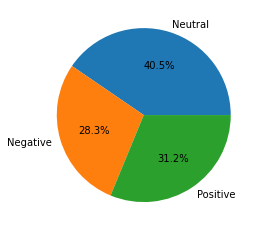

In [4]:
#visualization
neutral = len(data[data['sentiment'] == 0])
neg = len(data[data['sentiment'] == 1])
pos = len(data[data['sentiment'] == 2])
total_emo = [neutral,neg,pos]
plt.pie(total_emo, labels = ['Neutral','Negative','Positive'], autopct = '%1.1f%%')
plt.show()

In [5]:
data.dropna(inplace = True)
data.reset_index(inplace = True)
data.drop(columns = 'index', inplace = True)

In [6]:
# clean puntuation and convert lower case
data['selected_text'] = data['selected_text'].str.lower()
data['clean_text'] = data['selected_text'].str.replace('[{}]'.format(string.punctuation), '')
data.drop(columns = 'selected_text',inplace = True)

In [7]:
# tokenize sentence into words
nltk.download('punkt')
data['clean_text'] = data['clean_text'].apply(lambda item: word_tokenize(item))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [8]:
# install nltk stopwords
nltk.download('stopwords')
# remove stop words
data['clean_text'] = data['clean_text'].apply(lambda words : [ word for word in words if word not in stopwords.words('english')])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [9]:
# define stem method
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

# perform lemmatize
data['clean_text'] = data['clean_text'].apply(lambda sent: [stemmer.stem(word) for word in sent])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [10]:
data.head()

,sentiment,clean_text
0,0,"[respond, go]"
1,1,"[sooo, sad]"
2,1,[bulli]
3,1,"[leav, alon]"
4,1,[son]


In [11]:
def most_use_word(df):
  count_vectorizer = CountVectorizer(analyzer = lambda x:x)
  countVector = count_vectorizer.fit_transform(df['clean_text'])

  # Appliyng Countvectorizer
  print("{} Number of reviews has {} words".format(countVector.shape[0], countVector.shape[1]))

  count_vect_df = pd.DataFrame(countVector.toarray(), columns=count_vectorizer.get_feature_names())

  # Count text frqeuency
  count = pd.DataFrame(count_vect_df.sum())
  countdf = count.sort_values(by = 0, ascending = False).head(20)

  # Draw circle for visualization
  # Create a circle for the center of the plot
  my_circle=plt.Circle( (0,0), 0.7, color='white')
  plt.pie(countdf[:3], labels=countdf.index[:3], colors=['green','blue','red'])
  p=plt.gcf()
  p.gca().add_artist(my_circle)
  plt.show()

Most used negative words
7671 Number of reviews has 3615 words


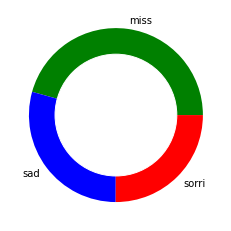


Most used postive words
11104 Number of reviews has 10761 words


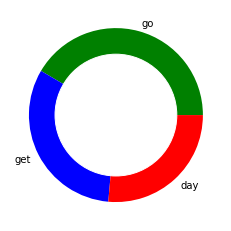

In [14]:
# Check most used workds for negative and positive sentiment
neg = data[data['sentiment'] == 1]
pos = data[data['sentiment'] == 0]

# Most Used Words
print("Most used negative words")
most_use_word(neg)

print()

print("Most used postive words")
most_use_word(pos)

In [15]:
# Apply TfidVectorizer
vectorizer = TfidfVectorizer(analyzer=lambda x: x)
x = vectorizer.fit_transform(data['clean_text'])

In [16]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(
    x, data['sentiment'], test_size=0.2, random_state=25)

In [17]:
# Model Generation Using Multinomial Naive Bayes
clf = BernoulliNB().fit(X_train, y_train)
predicted= clf.predict(X_test)
print("MultinomialNB Accuracy:",metrics.accuracy_score(y_test, predicted))

MultinomialNB Accuracy: 0.760329067641682


In [18]:
def prediction(sentence, vectorizer, model):
  #Apply preprocess steps
  lower_case = [word.lower() for word in sentence]
  cleaned_text = [word.translate(str.maketrans('','',string.punctuation)) for word in lower_case]
  tokenized_word = [word_tokenize(word) for word in cleaned_text]
  no_stop_word = [word for word in tokenized_word[0] if word not in stopwords.words("english")]

  #Vectorize the words
  vec_text = vectorizer.transform([no_stop_word])

  # #Prediction
  predicted = model.predict(vec_text)
  if predicted == 1:
    print("sentece {} is a negative comment!".format(sentence))
  elif predicted == 2:
    print("sentece {} is a positive comment!".format(sentence))
  else:
    print("sentece {} is a neutral comment!".format(sentence))

In [19]:
prediction(["I feel sad"], vectorizer, clf)

sentece ['I feel sad'] is a negative comment!


In [20]:
import dill as pickle

filename = "text_sentiment.pkl"
#Save model and vectorizer
with open(filename, "wb") as writer:
    pickle.dump((vectorizer,clf),writer)